# LDA 

- LDA : corpus에서 토픽을 찾아내는 분석 방법

In [1]:
#필요 라이브러리 import
#!pip3 install pyldavis # pyldavis 설치
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.sklearn
from gensim import corpora

import gensim
from gensim.models.coherencemodel import CoherenceModel

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from tqdm import tqdm
from konlpy.tag import Okt
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import RegexpTokenizer
import json
import matplotlib.pyplot as plt
import os
from matplotlib import rc
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\mh\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
#파일 불러오기
df = pd.read_csv('2_세탁인포.csv', encoding='utf-8-sig', index_col=0)
df.reset_index(inplace=True, drop=True) #인덱스 재설정
print(len(df))
df.head()

13697


,tit,body,comment,source,keyword,doc,target,okt
0,형제님들 LVC 뉴린스 세탁 어떻게들 하고 계십니까?,제목이 곧 내용입니다.사실 LVC47501 뉴린스 제품을 14년 초에 구입하면서 ...,"[['부담가지실 필요없이 그냥 세탁기에 돌리시면 됩니다!'], ['ㅎㅎ남자답게 한번...",E,세탁,형제님들 뉴린스 세탁 어떻게 들하고 계십니까 제목이 곧 내용입니다 사실 뉴린스 제품...,1.0,"['형제', '들다', '뉴', '린스', '세탁', '어떻다', '들다', '계시..."
1,비즈빔 룽타셔츠 세탁 질문입니다 !,기자원단에 뒤에 성조기 부분은 다른 소재라서요. 무턱대고 세탁소 맡기기도 애매하고 ...,[['감사합니다. 문의 드려봐야겠어요 :)']],E,세탁,비즈빔룽타 셔츠 세탁질문입니다기 자원단에 뒤에 성조기 부분은 다른 소재라서요무턱대고...,1.0,"['비즈', '빔룽타', '셔츠', '세탁', '질문', '이다', '자원', '단..."
2,레졸루트 워싱 질문드립니다.,작년 여름 즈음에 레졸루트를 구매하였는데요청바지를 자주 세탁하다보니 색상이 많이 빠...,[['인디고 염색특성 상 세탁을 지속적으로 한다면 페이딩이 빨리 생깁니다. 다만 전...,E,세탁,레졸 루트 워싱 질문 드립니다 작년 여름 즈음에 레졸 루트를 구매하였는데 요청 바지...,1.0,"['레졸', '루트', '워싱', '질문', '드리다', '작년', '여름', '즈..."
3,수선을 이따위로 해놨네요...,풀카운트 데님인데수선 맡기고 2주정도 있다가 오늘 드디어 입었습니다왼쪽 오른쪽 핏이...,"[['이건 무조건 환불 받아야죠\n데님의 생명은 핏인데요..'], ['아.. 동네 ...",E,세탁,수선을 이따위로 해놨네요 풀카운트 데님인데 수선 맡기고 주정도 있다가 오늘 드디어 ...,1.0,"['수선', '로', '풀', '카운트', '데님', '수선', '맡다', '주정'..."
4,"옷입을때 고민, 저만 이런가요..? ㅎㅎ",이번에 브라운야드 발마칸 코트를 구매하고 입고있는데이제 세번정도 입었는데 목쪽에 떼...,"[['포플린같은 재질이 특히 취약하더라구요!!'], ['ㅎㅎㅎ 이게 저만그런건 아니...",E,세탁,옷 입을 때 고민저만 이런 가요 이번에 브라운 야드발마칸 코트를 구매하고 입고 있는...,1.0,"['옷', '입', '때', '고민', '이렇다', '가요', '이번', '브라운'..."


In [3]:
#예시로 샘플링해서 진행**
df = df.sample(frac=0.2, random_state=4885)
print(len(df))
df.head()

2739


,tit,body,comment,source,keyword,doc,target,okt
4986,이지 신발세탁 맡겨보신분??,맡겨도 상관없을까요??,"[['전문 세탁 업체에 맡겨요'], ['전문세탁은 전문이라고 적혀잇나요?'], ['...",A,세탁,이지신발 세탁 맡겨보신 분맡겨도 상관없을까요 전문 세탁업체에 맡겨 요 전문 세탁은 ...,1.0,"['신발', '세탁', '맡기다', '보신', '분', '맡기다', '상관없다', ..."
3501,스톤 트레이닝 조거,"\n \n \n \n이거 무릎 늘어나느거 어덕하죠 ???해결책 잇나요 ,,",[['세탁하시면 쫙 들어갑니다\n자주 세탁하면 옷 상하니깐 한번입고 무릎쪽 사타구니...,F,세탁,스톤트레이닝 조거글 작성 시 배너를 삭제하시면 활동정지 대상이 오니 유의하시기 바랍...,1.0,"['스톤', '트레이닝', '조거', '글', '작성', '시', '배너', '삭제..."
5289,슬랙스 그냥 지마켓에서 구입햇는데,세탁기 돌려도 될까요?바지엔 손세탁하라고되어잇는데 드럼 손세탁기능으로 해서 다른것도...,"[['여주이름이뭐였었죠..까먹음 ㅜ'], ['알렉산드리아 다다리오']]",A,세탁,슬랙스 그냥 지마켓에서 구입 햇는데 세탁기 돌려도 될까요 바지엔 손세탁하라고 되어 ...,1.0,"['슬랙스', '그냥', '지마켓', '구입', '햇', '늘다', '세탁기', '..."
4504,구찌 스니커즈,더러워져서레더 플레인이라는곳에 드라이 맡겼는데음 14일째 소식이 없네요전화해보니 본...,[['명품은 시간이 오래 걸립니다... 길게는 한달 걸리기도 합니다.. 상태에 따라...,A,세탁,구찌 스니커즈더러워져서 레더 플레인이라는 곳에 드라이 맡겼는데 음일째 소식이 없네요...,1.0,"['구찌', '스니커즈', '더러워지다', '레더', '플레인', '곳', '드라이..."
13465,청바지 모드나인 vs 리바이스,어느정도 차이있나요?퀄 적으로. 가격은 비슷해보이는데요 리바이스 세일하면.,[['내구도 부터 무조건 리바이스요.국내 브랜드 치고 세탁 후 오래 입는바지 못 본...,A,세탁,청바지 모드나인 리바이스 어느 정도 차이 있나 요퀄적으로 가격은 비슷해 보이는데 요...,1.0,"['청바지', '모드', '나인', '리바이스', '정도', '차이', '있다', ..."


- 함수 미리 정의

1. 토픽 수 바꿔가며 도출할 perplexity와 토픽당 대표 단어 리스트 함수
2. LDA 진행 후 해당 토픽에 원문을 할당하기 위한 함수 (threshold 지정)
3. LDA 진행 후 해당 토픽에 원문을 할당하기 위한 함수 (threshold 지정X)

In [4]:
# 토픽 수가 n개일 때의 perplexity와 토픽당 대표 단어를 20개 뽑는 함수
# dtm = 데이터를 tf-idf 벡터에 적용한 것 # dtm = tf_vect.fit_transform(df['doc'])
# lda = 데이터를 n_components의 수의 토픽으로 분할한 모델 # lda = LatentDirichletAllocation(n_components=i, random_state=0, learning_method='batch', max_iter=20) 

def topic_words(dtm, lda):
    
    topics_word_list = [] #토픽당 대표단어를 저장할 리스트
    names = tf_vect.get_feature_names() #get_feature_names()로 벡터화시킨 feature(단어들)을 확인

    topics_word = dict()
    n_words = 20 # 대표 단어 수를 조절하고 싶으면 여기를 수정
    
    for idx, topic in enumerate(lda.components_): #components_속성은 n개의 토픽별(row)로 해당 feature(단어)들의 분포수치(column)를 보여줌 #토픽별로 어떤 단어들이 많이 분포하는지 확인가능
        vocab = []
        for i in topic.argsort()[: -(n_words-1): -1]:   # Topic별로 단어들(features)중에서 높은 값 순으로 정렬 후 index를 반환해줌
                                                        # argsort()는 디폴트가 오름차순임(1,2,3,...) 그래서 [::-1]로 내림차순으로 바꿔주기
            vocab.append((names[i], topic[i].round(2)))
        topics_word[idx + 1] = vocab
    topics_word_list.append(topics_word)
    
    return lda.perplexity(dtm), topics_word_list

In [5]:
# 어떤 원문이 토픽 k에 할당될 확률이 threshold 이상일 때에만 그 원문을 토픽 k에 할당하는 함수
# data = 전처리된 문단 단위의 데이터
# dtm = 데이터를 tf-idf 벡터에 적용한 것
# lda = 데이터를 n_components의 수의 토픽으로 분할한 모델
# threshold = 하이퍼 파라미터, 어떤 원문이 토픽 k에 할당될 확률의 하한선
def original_sentence_threshold(data, dtm, lda, threshold):
    topic = []
    weight = []
    
    for i in lda.transform(dtm):
        t = i.argmax()
        
        if i[t] < threshold:
            topic.append("No")
            weight.append(i[t])
        
        else:
            topic.append(t)
            weight.append(i[t])
        
    data["topic"] = topic
    data["weight"] = weight
    
    useless = data[data["topic"] == "No"].index
    data = data.drop(useless)
    
    return data

In [6]:
# 토픽 k에 할당될 확률이 가장 높은 원문을 토픽 k에 할당하는 함수
# data = 전처리된 문단 단위의 데이터
# dtm = 데이터를 tf-idf 벡터에 적용한 것
# lda = 데이터를 n_components의 수의 토픽으로 분할한 모델
def original_sentence_all(data, dtm, lda):
    topic = []
    weight = []
    
    for i in lda.transform(dtm):
        t = i.argmax()
        topic.append(t)
        weight.append(i[t])
    data["topic"] = topic
    data["weight"] = weight
    
    return data

In [7]:
okt = Okt() 

In [8]:
def preprocess_okt(text):
    #     text = spacing(text) # 띄어쓰기 보정 위에서 했으면 필요없습니다
    pos_words = okt.pos(text, stem=True)
    words = [word for word, tag in pos_words if tag in ['Noun', 'Adjective', 'Verb'] ]
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','요']
    stopped_words = [w for w in words if not w in stopwords]
    return stopped_words

In [9]:
# 토픽 개수가 정해지지 않았을 때, 지정된 모든 토픽의 perlexity, 대표 단어, 원문을 원큐에 뽑는 코드

topics_word_list = []
topics_document_list = []
perplexity_list = []
topics_document_all_list = []

topic_num = 20 #2개부터 20개까지

num_topic = range(2, topic_num+1) # range(a, b) = 토픽 개수가 a개 ~ b-1개인 경우를 모두 뽑음
tf_vect = TfidfVectorizer(tokenizer=preprocess_okt, ngram_range=(2,3), min_df=5) # n_gram 설정
dtm = tf_vect.fit_transform(df['doc'])

for i in num_topic:
    lda = LatentDirichletAllocation(n_components=i, random_state=0, learning_method='batch', max_iter=20) #LDA
    lda.fit(dtm) 

    visual = pyLDAvis.sklearn.prepare(lda, dtm, tf_vect) #pyLDAvis LDA 시각화 

    pyLDAvis.save_html(visual, 'LDA_topic{}개.html'.format(i)) #파일 이름 지정
    
    a, b = topic_words(dtm, lda)
    perplexity_list.append(a)
    topics_word_list.append(b)
    
    topics_document_list.append(original_sentence_threshold(df, dtm, lda, 0.75))
    topics_document_all_list.append(original_sentence_all(df, dtm, lda))
    
    print("토픽 {0}개짜리 LDA 완료".format(i)) #과정 출력

토픽 2개짜리 LDA 완료
토픽 3개짜리 LDA 완료
토픽 4개짜리 LDA 완료
토픽 5개짜리 LDA 완료
토픽 6개짜리 LDA 완료
토픽 7개짜리 LDA 완료
토픽 8개짜리 LDA 완료
토픽 9개짜리 LDA 완료
토픽 10개짜리 LDA 완료
토픽 11개짜리 LDA 완료
토픽 12개짜리 LDA 완료
토픽 13개짜리 LDA 완료
토픽 14개짜리 LDA 완료
토픽 15개짜리 LDA 완료
토픽 16개짜리 LDA 완료
토픽 17개짜리 LDA 완료
토픽 18개짜리 LDA 완료
토픽 19개짜리 LDA 완료
토픽 20개짜리 LDA 완료


=> 토픽 2,3,4,5,6,7 ... 짜리 lda html 링크로 저장됨. 폴더에서 확인

- 토픽의 개수에 따라 perplexity(혼잡도) 정량적 확인

[9180.983082292181, 12139.77325220643, 15351.520246167825, 18219.36125341667, 22967.142639520378, 29580.200291379755, 35941.52883756408, 43946.230252648726, 54922.24997198577, 59297.06121790916, 84463.61042975543, 88191.50741384593, 85572.94659294619, 106999.06033177268, 115992.21709342711, 160125.89399392984, 162186.06423977096, 172173.2094033656, 171929.88165235578]


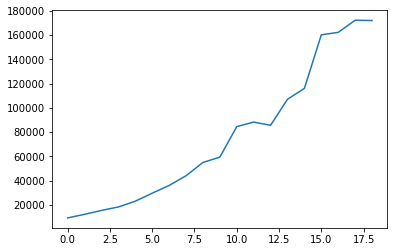

In [10]:
print(perplexity_list)
plt.plot(perplexity_list)

- 토픽의 개수에 따른 top 단어 확인

In [11]:
#토픽 개수별 top 단어 확인
print(topics_word_list[0])

[{1: [('거 같다', 44.72), ('것 같다', 39.61), ('수 있다', 30.28), ('세탁 후', 21.92), ('안 되다', 16.07), ('수축 있다', 15.24), ('수축 되다', 15.15), ('세탁 수축', 14.17), ('세탁 시', 13.69), ('번 세탁', 13.16), ('추천 해주다', 12.43), ('입다 있다', 11.98), ('되다 거', 11.9), ('몇 번', 11.66), ('답변 감사하다', 11.54), ('세탁 번', 11.43), ('있다 거', 10.56), ('수축 없다', 10.41)], 2: [('세탁 어떻다', 41.08), ('세탁기 돌리다', 37.13), ('손 빨래', 32.86), ('손 세탁', 32.26), ('안 되다', 27.67), ('섬유 유연제', 19.83), ('어떻다 세탁', 19.6), ('거 같다', 18.92), ('세탁 안', 18.62), ('물 세탁', 17.82), ('활동 정지', 17.69), ('돌리다 되다', 17.47), ('세탁 망', 17.45), ('드라이 맡기다', 17.25), ('그냥 세탁기', 16.51), ('망 넣다', 16.28), ('세탁소 맡기다', 16.25), ('린 토피아', 15.91)]}]


In [12]:
topics_word_list

[[{1: [('거 같다', 44.72),
    ('것 같다', 39.61),
    ('수 있다', 30.28),
    ('세탁 후', 21.92),
    ('안 되다', 16.07),
    ('수축 있다', 15.24),
    ('수축 되다', 15.15),
    ('세탁 수축', 14.17),
    ('세탁 시', 13.69),
    ('번 세탁', 13.16),
    ('추천 해주다', 12.43),
    ('입다 있다', 11.98),
    ('되다 거', 11.9),
    ('몇 번', 11.66),
    ('답변 감사하다', 11.54),
    ('세탁 번', 11.43),
    ('있다 거', 10.56),
    ('수축 없다', 10.41)],
   2: [('세탁 어떻다', 41.08),
    ('세탁기 돌리다', 37.13),
    ('손 빨래', 32.86),
    ('손 세탁', 32.26),
    ('안 되다', 27.67),
    ('섬유 유연제', 19.83),
    ('어떻다 세탁', 19.6),
    ('거 같다', 18.92),
    ('세탁 안', 18.62),
    ('물 세탁', 17.82),
    ('활동 정지', 17.69),
    ('돌리다 되다', 17.47),
    ('세탁 망', 17.45),
    ('드라이 맡기다', 17.25),
    ('그냥 세탁기', 16.51),
    ('망 넣다', 16.28),
    ('세탁소 맡기다', 16.25),
    ('린 토피아', 15.91)]}],
 [{1: [('신발 세탁', 14.27),
    ('섬유 유연제', 7.67),
    ('클리 너', 6.65),
    ('세탁 곳', 6.12),
    ('추천 해주다', 5.76),
    ('세탁 맡기다', 4.97),
    ('빨래 방', 4.36),
    ('세탁 방', 4.14),
    ('코인 세탁', 3.96),
    ('곳 추천', 3

In [13]:
#토픽별 top단어 메모장에 뽑아두기
f = open("단어top20.txt", 'w')
for i in range(len(topics_word_list)):
    f.write('\n')
    f.write('topic_num{}개 일때'.format(i+2))
    f.write('\n')
    for j in range(1, 3+i):
        f.write('{}번째 토픽'.format(j))
        f.write('\n')
        f.write('\n')
        for k in range(len(topics_word_list[i][0][j])):
            f.write(str(topics_word_list[i][0][j][k]))
            f.write('\n')
f.close()

=> 토픽 2,3,4,5,6,7 ... 짜리 토픽별 top단어 텍스트로 저장. 폴더에서 확인